<a href="https://colab.research.google.com/github/chanhyeong00/machine_learning_study/blob/main/6_%EC%9E%84%EB%B2%A0%EB%94%A9%EC%9D%84_%EC%82%AC%EC%9A%A9%ED%95%9C_%EA%B0%90%EC%84%B1%ED%94%84%EB%A1%9C%EA%B7%B8%EB%9E%98%EB%B0%8D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

이 장에서는 감성 프로그래밍의 작동 방식을 알아본다.

5장에서 사용한 sarcasm 데이터셋을 사용해 임베딩으로 문장에서 빈정거림을 감지하는 모델을 만든다.

### 6.1. 단어의 의미 구축하기

#### 간단한 방법: 양수와 음수

수천개의 헤드라인을 통해 빈정거림이 있는 문장의 단어들은 -1, 긍정이면 +1을 해서 점수를 매기는 방식

(거대한 단어 리스트로)

#### 조금 더 어려운 방법: 벡터

### 6.2. 텐서플로 임베딩

tf.keras는 층을 사용해 임베딩을 구현한다. 이 층은 정수를 임베딩벡터로 매핑하는 룩업 테이블을 만든다.

이 테이블은 정수로 표현된 단어의 벡터를 담고 있다.

벡터 공간에 있는 한 벡터의 방향이 단어의 의미를 인코딩한다. 비슷한 방향을 가리키는 벡터를 가진 단어들은 서로 연관된다.

임베딩 층은 초기에 랜덤하게 초기화, 시작할 때 벡터의 좌표가 완전히 랜덤하게 설정되고 훈련 과정에서 역전파 학습한다.

훈련 종료후 임베딩은 단어 사이의 유사성을 인코딩하기 때문에 단어의 벡터 방향 기반으로 비슷한 단어를 식별한다

#### 6.2.1. 임베딩을 사용해 빈정거림 감지기 만들기

##### 데이터셋 준비 및 전처리

In [1]:
import tensorflow as tf

In [2]:
# 데이터 전처리
from bs4 import BeautifulSoup
import json
import string

stopwords = ["a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at",
             "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do",
             "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having",
             "he", "hed", "hes", "her", "here", "heres", "hers", "herself", "him", "himself", "his", "how",
             "hows", "i", "id", "ill", "im", "ive", "if", "in", "into", "is", "it", "its", "itself",
             "lets", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought",
             "our", "ours", "ourselves", "out", "over", "own", "same", "she", "shed", "shell", "shes", "should",
             "so", "some", "such", "than", "that", "thats", "the", "their", "theirs", "them", "themselves", "then",
             "there", "theres", "these", "they", "theyd", "theyll", "theyre", "theyve", "this", "those", "through",
             "to", "too", "under", "until", "up", "very", "was", "we", "wed", "well", "were", "weve", "were",
             "what", "whats", "when", "whens", "where", "wheres", "which", "while", "who", "whos", "whom", "why",
             "whys", "with", "would", "you", "youd", "youll", "youre", "youve", "your", "yours", "yourself",
             "yourselves"]


with open("sarcasm.json", 'r') as f:
    datastore = json.load(f)

table = str.maketrans('', '', string.punctuation) # 구두점 제거하기 위한 테이블
sentences = []
labels = []
urls = []
for item in datastore:
    sentence = item['headline'].lower()
    sentence = sentence.replace(",", " , ")
    sentence = sentence.replace(".", " . ")
    sentence = sentence.replace("-", " - ")
    sentence = sentence.replace("/", " / ")
    soup = BeautifulSoup(sentence)
    sentence = soup.get_text()
    words = sentence.split()
    filtered_sentence = ""
    for word in words:
        word = word.translate(table)
        if word not in stopwords:
            filtered_sentence = filtered_sentence + word + " "
    sentences.append(filtered_sentence)
    labels.append(item['is_sarcastic'])
    urls.append(item['article_link'])

<ipython-input-2-b86debca64de>:34: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(sentence)


In [8]:
vocab_size = 10_000
embedding_dim = 16
max_length = 100
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 23_000

In [4]:
training_sentences = sentences[0:training_size]
test_sentences = sentences[training_size:]
training_labels = labels[0:training_size]
test_labels = labels[training_size:]


In [10]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(test_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [11]:
import numpy as np
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(test_labels)

In [43]:
#tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)

임베딩 층을 초기화하기 위해 다음처럼 어휘 사전 크기와 임베딩 차원을 먼저 지정해야한다.

In [13]:
tf.keras.layers.Embedding(vocab_size, embedding_dim)

각 단어에 대해 embedding_dim 차원의 배열 초기화.

훈련 데이터의 입력과 레이블을 매핑하기 위해 신경망이 훈련될 떄 역전파를 통해 이 벡터가 학습된다.


임베딩 층의 출력을 밀집 층에 전달하는 다음 단계가 중요하다. 합성곱 신경망에서 했던 작업과 유사하게 풀링을 사용하면 가장 쉽다.

이 경우 임베딩 차원을 평균하여 고정 길이의 출력 벡터를 만든다.

다음같은 신경망을 생각해보자

In [15]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(10000, 16),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')

])
model.compile(loss='binary_crossentropy', optimizer='adam',
               metrics=['accuracy'])

In [16]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 16)          160000    
                                                                 
 global_average_pooling1d_1  (None, 16)                0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_2 (Dense)             (None, 24)                408       
                                                                 
 dense_3 (Dense)             (None, 1)                 25        
                                                                 
Total params: 160433 (626.69 KB)
Trainable params: 160433 (626.69 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


- 임베딩의 어휘 사전 크기가 10,000이고 각 단어의 벡터는 16차원이기 떄문에 임베딩 층의 훈련 가능한 전체 파라미터 개수는 10000 * 16 = 160,000개이다..

- 평균 풀링층은 임베딩층의 출력을 단순히 평균하여 16차원 벡터를 만들기 때문에 파라미터가 없다.

- 그다음 24개 뉴런을 가진 밀집층에 이를 전달. 밀집 층은 가중치와 절편을 가지고 있으므로 (24*16) + 16 = 408개의 파라미터 학습

- 이 층의 출력이 하나의 뉴런을 가진 마지막 층에 전달. 1*24 + 1 = 25개 파라미터


In [17]:
num_epochs = 30
history = model.fit(training_padded, training_labels, epochs=num_epochs,
                    validation_data=(testing_padded, testing_labels))

Epoch 1/30
719/719 [==============================] - 4s 4ms/step - loss: 0.6803 - accuracy: 0.5616 - val_loss: 0.6552 - val_accuracy: 0.6112
Epoch 2/30
719/719 [==============================] - 3s 4ms/step - loss: 0.5532 - accuracy: 0.7303 - val_loss: 0.4813 - val_accuracy: 0.7722
Epoch 3/30
719/719 [==============================] - 4s 5ms/step - loss: 0.3981 - accuracy: 0.8283 - val_loss: 0.4320 - val_accuracy: 0.7997
Epoch 4/30
719/719 [==============================] - 2s 3ms/step - loss: 0.3321 - accuracy: 0.8599 - val_loss: 0.4211 - val_accuracy: 0.8032
Epoch 5/30
719/719 [==============================] - 3s 4ms/step - loss: 0.2922 - accuracy: 0.8779 - val_loss: 0.4294 - val_accuracy: 0.8010
Epoch 6/30
719/719 [==============================] - 2s 3ms/step - loss: 0.2642 - accuracy: 0.8917 - val_loss: 0.4329 - val_accuracy: 0.8078
Epoch 7/30
719/719 [==============================] - 3s 4ms/step - loss: 0.2431 - accuracy: 0.9004 - val_loss: 0.4453 - val_accuracy: 0.8024
Epoch 

이 모델을 훈련하면 30번의 에폭 후에 96% 이상의 꽤 높은 정확도를 얻을 수 있다. 그러나 검증 정확도는 78%이다.

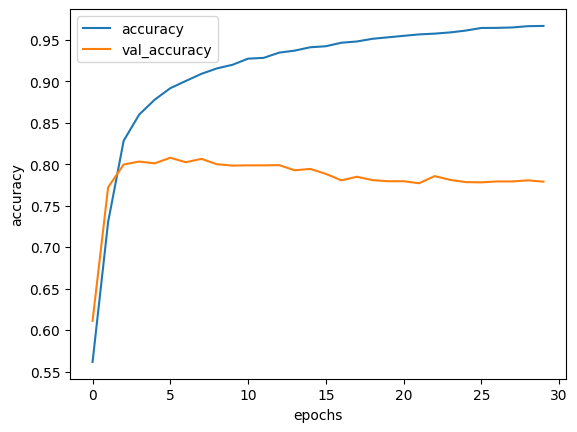

In [18]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

훈련 데이터에 없는 단어가 검증 데이터

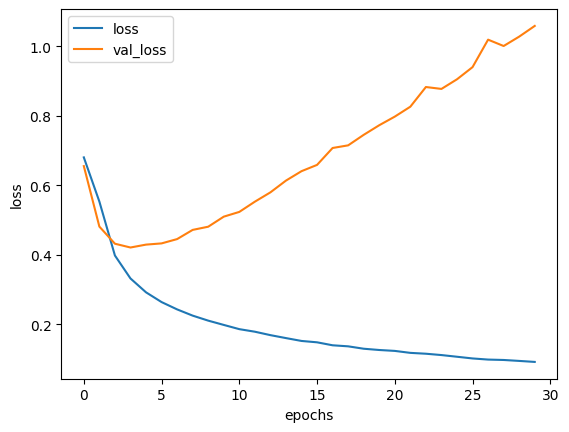

In [19]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['loss', 'val_loss'])
plt.show()

그래프를 보면 검증 정확도가 조금 떨어지는 동안 손실이 급격히 올라가기 때문에 과대적합이 두드러지게 나타난다.

언어의 예측 불가능한 성질 때문에 과대적합 현상은 자연어 처리 모델에서 흔히 관측된다.

이런 현상을 감소시키는 몇 가지 방법을 다음 절에서 알아보겠다.

#### 6.2.2. 언어 모델의 과대적합 줄이기

##### **학습률 조정하기**
괘대적합을 일으키는 가장 큰 요소는 옵티마이저의 학습률이 너무 높은 경우이다.

즉 신경망이 너무 빠르게 학습한다는 의미이다.

In [26]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

adam = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9,
                                beta_2=0.999, amsgrad=False)

model.compile(loss='binary_crossentropy', optimizer=adam,
               metrics=['accuracy'])

기본값이 0.001인 학습률을 0.0001로 지정했다.

beta_1과 beta_2, amsgrad는 기본값을 그대로 사용한다.

beta_1과 beta_2는 0-1 사이여야 하고 일반적으로 둘 다 1에 가까운 값을 지정한다.

amsgrad는 한 논문에서 소개된 Adam 옵티마이저의 또 다른 구현이다.

In [27]:
num_epochs = 100
history = model.fit(training_padded, training_labels, epochs=num_epochs,
                    validation_data=(testing_padded, testing_labels))

Epoch 1/100
719/719 [==============================] - 5s 5ms/step - loss: 0.6895 - accuracy: 0.5502 - val_loss: 0.6848 - val_accuracy: 0.5700
Epoch 2/100
719/719 [==============================] - 2s 3ms/step - loss: 0.6855 - accuracy: 0.5596 - val_loss: 0.6826 - val_accuracy: 0.5700
Epoch 3/100
719/719 [==============================] - 2s 3ms/step - loss: 0.6846 - accuracy: 0.5596 - val_loss: 0.6818 - val_accuracy: 0.5700
Epoch 4/100
719/719 [==============================] - 3s 4ms/step - loss: 0.6837 - accuracy: 0.5596 - val_loss: 0.6808 - val_accuracy: 0.5700
Epoch 5/100
719/719 [==============================] - 4s 5ms/step - loss: 0.6824 - accuracy: 0.5596 - val_loss: 0.6793 - val_accuracy: 0.5700
Epoch 6/100
719/719 [==============================] - 3s 3ms/step - loss: 0.6805 - accuracy: 0.5596 - val_loss: 0.6774 - val_accuracy: 0.5700
Epoch 7/100
719/719 [==============================] - 3s 3ms/step - loss: 0.6775 - accuracy: 0.5596 - val_loss: 0.6736 - val_accuracy: 0.5700

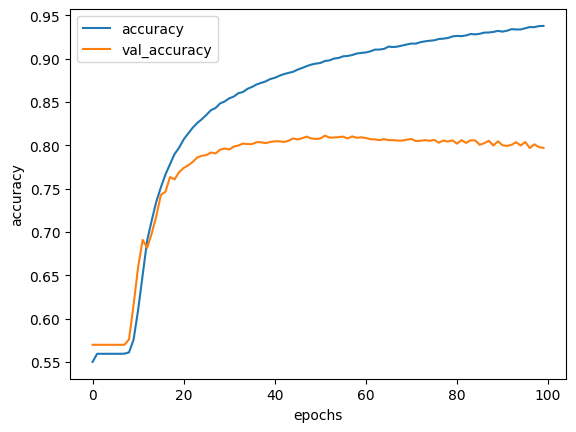

In [28]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

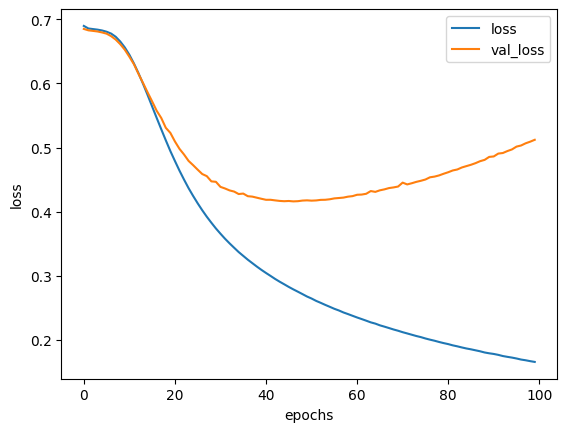

In [29]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['loss', 'val_loss'])
plt.show()

신경망이 좋은 정확도에 도달하기까지 기존보다 더 오래 걸리지만 손실은 낮으므로 더 좋은 결과를 얻을 수 있다.

이 하이퍼파라미터에서는 검증세트 손실이 약 60번째 에폭에서 증가하기 시작한다.

이 지점에서 훈련세트의 정확도는 90%이고, 검증 세트의 정확도는 약 81%이므로 꽤 훌륭한 신경망을 얻을 수 있다.

이외에도 모델을 향상하는 방법이 더 있다.

##### **어휘 사전 크기 바꾸기**

sarcasm 데이터셋에서는 단어를 다루기 때문에 데이터셋에 있는 단어, 특히 빈도를 살펴보면 과대적합 이슈를 고치는 데 도움이 될 수 있다.

tokenizer 객체의 word_counts 속성을 사용하면 단어의 빈도를 확인할 수 있다. 다음처럼 이 속성을 출력하면 단어 카운트의 튜플을 담은 **OrderedDict** 반환

In [42]:
# 위에서 초기화해버려서 다시
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

wc=tokenizer.word_counts
# 출력이 길어 노트북에서 제외함
print(wc)

OrderedDict([('former', 90), ('versace', 1), ('store', 44), ('clerk', 9), ('sues', 13), ('secret', 78), ('black', 230), ('code', 19), ('minority', 12), ('shoppers', 2), ('roseanne', 3), ('revival', 10), ('catches', 10), ('thorny', 3), ('political', 73), ('mood', 13), ('better', 100), ('worse', 34), ('mom', 163), ('starting', 37), ('fear', 39), ('sons', 35), ('web', 16), ('series', 53), ('closest', 5), ('thing', 126), ('will', 484), ('grandchild', 2), ('boehner', 26), ('just', 501), ('wants', 120), ('wife', 73), ('listen', 21), ('not', 634), ('come', 92), ('alternative', 13), ('debt', 23), ('reduction', 4), ('ideas', 35), ('j', 41), ('k', 39), ('rowling', 5), ('wishes', 33), ('snape', 2), ('happy', 51), ('birthday', 57), ('magical', 25), ('way', 239), ('advancing', 2), ('worlds', 79), ('women', 289), ('fascinating', 3), ('case', 77), ('eating', 64), ('lab', 8), ('grown', 17), ('meat', 25), ('ceo', 56), ('send', 33), ('kids', 164), ('school', 207), ('work', 168), ('company', 78), ('top',

단어의 순서는 데이터셋에 등장하는 순서대로 결정된다.

훈련세트에 있는 첫 번째 샘플을 보면 베르사체 매장에서 일했던 이전 직원을 비꼬는 헤드라인이다.

불용어는 삭제됨.

**OrderedDict** 를 사용해 단어 빈도의 역순으로 정리 가능

In [52]:
from collections import OrderedDict
newlist = (OrderedDict(sorted(wc.items(), key=lambda x:x[1], reverse=True)))
print(newlist)

OrderedDict([('new', 1318), ('trump', 1117), ('man', 1075), ('not', 634), ('just', 501), ('will', 484), ('one', 469), ('year', 440), ('report', 434), ('area', 421), ('donald', 407), ('day', 398), ('u', 398), ('s', 392), ('can', 387), ('says', 385), ('woman', 378), ('first', 376), ('time', 365), ('like', 356), ('no', 352), ('get', 346), ('old', 332), ('trumps', 331), ('off', 326), ('now', 325), ('life', 319), ('obama', 317), ('people', 311), ('house', 290), ('women', 289), ('white', 281), ('back', 278), ('still', 276), ('make', 275), ('clinton', 264), ('5', 260), ('world', 251), ('americans', 246), ('years', 240), ('way', 239), ('family', 231), ('black', 230), ('study', 225), ('gop', 218), ('best', 215), ('bill', 211), ('american', 208), ('school', 207), ('police', 206), ('watch', 206), ('3', 205), ('show', 205), ('really', 200), ('president', 198), ('home', 196), ('last', 194), ('video', 194), ('finds', 194), ('death', 193), ('cant', 193), ('know', 193), ('10', 192), ('things', 191), (

이를 그래프로 그린다.

x축 값은 항목의 순서로 설정 가능

y축값은 newlist [ item ] (빈도) 가 된다.

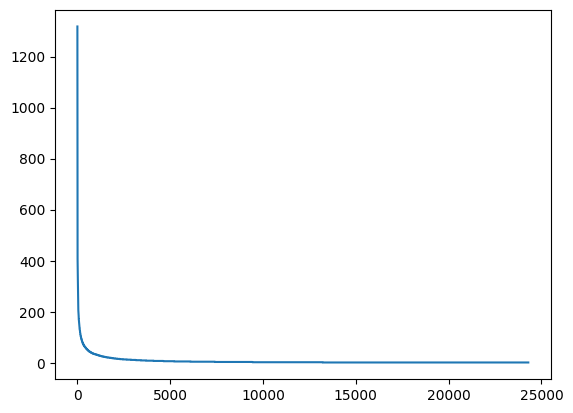

In [53]:
xs = []
ys = []
curr_x = 1
for item in newlist: # item은 키값을 나타낸다
  xs.append(curr_x)
  curr_x += 1
  ys.append(newlist[item])
plt.plot(xs, ys)
plt.show()

이런 하키 스틱 같은 곡선은 많이 사용되는 단어는 소수이고, 대부분의 단어는 매우 적게 사용된다는 것을 보여준다

***하지만 모든 단어는 임베딩의 한 항목이기 때문에 중요도는 모두 동일하다.***

검증세트보다 큰 훈련세트를 사용한다면 훈련세트에 있는 단어가 검증 세트에는 없는 상황이 많이 발생할 것이다.

- x 축을 300-10,000, y 축을 0-100으로 설정

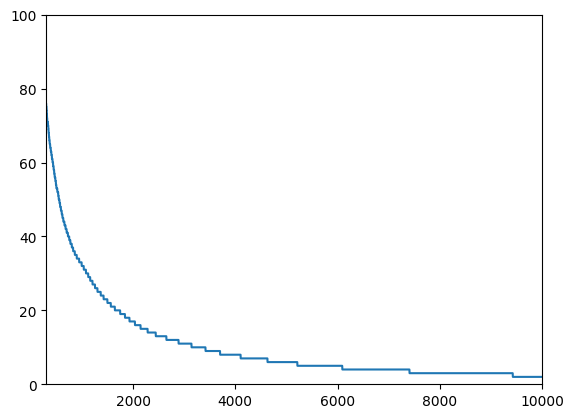

In [55]:
plt.plot(xs, ys)
plt.axis([300,10000, 0, 100])
plt.show()

말뭉치에 20,000 개 이상의 단어가 있지만 200~10,000 사이에 있는 단어는 20번 이하로 사용된다.

이 현상으로 과대적합을 설명할 수 있다. 어휘 사전 크기를 2,000 개로 바꾸어 다시 훈련하면 과대적합을 제거할 수 있다.

In [57]:
vocab_size = 2000


tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(test_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [58]:
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

In [59]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',
              optimizer='adam',metrics=['accuracy']) # 옵티마이저 영향 안 받기 위해 건들지 않음

In [60]:
num_epochs = 30
history = model.fit(training_padded, training_labels, epochs=num_epochs,
                    validation_data=(testing_padded, testing_labels))

Epoch 1/30
719/719 [==============================] - 3s 3ms/step - loss: 0.6767 - accuracy: 0.5675 - val_loss: 0.6453 - val_accuracy: 0.5915
Epoch 2/30
719/719 [==============================] - 2s 2ms/step - loss: 0.5662 - accuracy: 0.7108 - val_loss: 0.5140 - val_accuracy: 0.7447
Epoch 3/30
719/719 [==============================] - 2s 2ms/step - loss: 0.4668 - accuracy: 0.7771 - val_loss: 0.4815 - val_accuracy: 0.7598
Epoch 4/30
719/719 [==============================] - 2s 2ms/step - loss: 0.4329 - accuracy: 0.7910 - val_loss: 0.4633 - val_accuracy: 0.7719
Epoch 5/30
719/719 [==============================] - 2s 3ms/step - loss: 0.4188 - accuracy: 0.7988 - val_loss: 0.4618 - val_accuracy: 0.7743
Epoch 6/30
719/719 [==============================] - 2s 3ms/step - loss: 0.4100 - accuracy: 0.8025 - val_loss: 0.4624 - val_accuracy: 0.7722
Epoch 7/30
719/719 [==============================] - 2s 2ms/step - loss: 0.4067 - accuracy: 0.8061 - val_loss: 0.4616 - val_accuracy: 0.7781
Epoch 

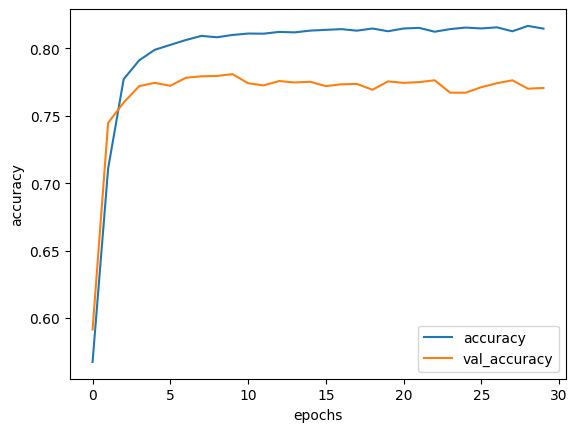

In [61]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

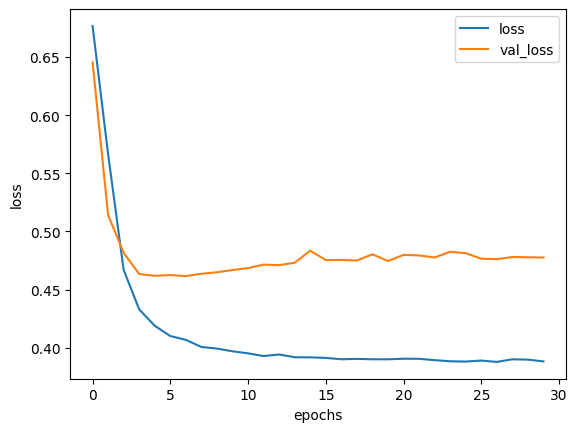

In [62]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['loss', 'val_loss'])
plt.show()

다른 크기의 어휘사전으로 실험해볼 가치가 있다. **하지만 어휘사전 크기가 너무 작아도 과대적합될 수 있다.**

둘 사이의 균형을 찾아야 한다. 여기서는 임의로 20번 이상 나오는 단어를 선택했다

##### **임베딩 차원 바꾸기**
이번 예제에서는 임의로 임베딩 차원 16을 선택했다. 단어는 16차원 공간상의 벡터로 인코딩된다.

하지만 16이 좋은 값일까? 어휘사전엔 2,000개의 단어만 있기 때문에 벡터의 일부 원소가 비어있거나 작은 값일 수 있다.

**임베딩 크기를 결정하는 모범 사례는 어휘 사전의 네제곱근을 사용하는 것이다.**

2000의 네 제곱근은 6.687이다. 그럼 임베딩 차원을 7로 바꾸고 100번의 에폭 동안 모델을 훈련하면 어떻게 되는지 보겠다.

In [63]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, 7),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',
              optimizer='adam',metrics=['accuracy']) # 옵티마이저 영향 안 받기 위해 건들지 않음

history = model.fit(training_padded, training_labels, epochs=100,
                    validation_data=(testing_padded, testing_labels))

Epoch 1/100
719/719 [==============================] - 4s 3ms/step - loss: 0.6847 - accuracy: 0.5590 - val_loss: 0.6755 - val_accuracy: 0.5700
Epoch 2/100
719/719 [==============================] - 1s 2ms/step - loss: 0.6293 - accuracy: 0.6502 - val_loss: 0.5711 - val_accuracy: 0.7234
Epoch 3/100
719/719 [==============================] - 1s 2ms/step - loss: 0.5154 - accuracy: 0.7546 - val_loss: 0.4954 - val_accuracy: 0.7579
Epoch 4/100
719/719 [==============================] - 2s 3ms/step - loss: 0.4595 - accuracy: 0.7816 - val_loss: 0.4816 - val_accuracy: 0.7582
Epoch 5/100
719/719 [==============================] - 1s 2ms/step - loss: 0.4351 - accuracy: 0.7902 - val_loss: 0.4655 - val_accuracy: 0.7735
Epoch 6/100
719/719 [==============================] - 1s 2ms/step - loss: 0.4225 - accuracy: 0.7959 - val_loss: 0.4653 - val_accuracy: 0.7722
Epoch 7/100
719/719 [==============================] - 2s 2ms/step - loss: 0.4136 - accuracy: 0.8017 - val_loss: 0.4618 - val_accuracy: 0.7778

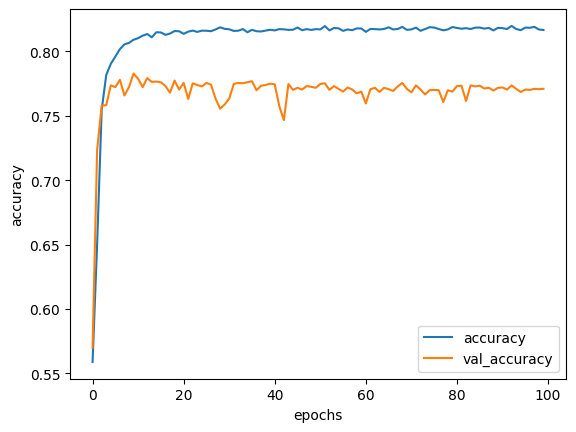

In [64]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

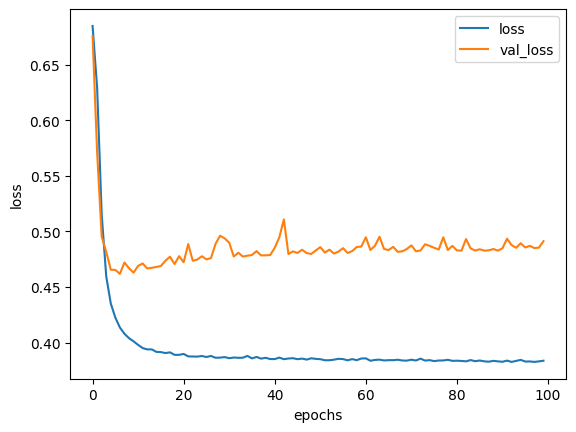

In [65]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['loss', 'val_loss'])
plt.show()

훈련세트 정확도는 약 80%에 안정화되고, 검증세트 정확도는 약 77%이다.

약간의 굴곡이 있지만 전체 곡선은 꽤 평평하므로 모델이 수렴한다는 것을 보여준다.

이 결과는 바로 이전과 크게 다르진 않지만 임베딩 차원을 줄였기 떄문에 모델 훈련속도가 30% 이상 빨라졌다.

손실곡선도 평평해졌다. 좋은 신호이다.

이제 차원을 줄였으므로 다음으로 모델 구조를 조금 바꿔볼 수 있다.

##### **모델 구조 변경하기**

24개의 밀집층에 전달하면 크기가 과도하게 커진다.

밀집층의 뉴련을 8개로 줄이고 100번의 에폭동안 훈련해보았다.

In [66]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, 7),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy',
              optimizer='adam',metrics=['accuracy']) # 옵티마이저 영향 안 받기 위해 건들지 않음

history = model.fit(training_padded, training_labels, epochs=100,
                    validation_data=(testing_padded, testing_labels))

Epoch 1/100
719/719 [==============================] - 3s 3ms/step - loss: 0.6841 - accuracy: 0.5583 - val_loss: 0.6774 - val_accuracy: 0.5700
Epoch 2/100
719/719 [==============================] - 3s 4ms/step - loss: 0.6510 - accuracy: 0.6111 - val_loss: 0.6065 - val_accuracy: 0.6824
Epoch 3/100
719/719 [==============================] - 2s 3ms/step - loss: 0.5563 - accuracy: 0.7298 - val_loss: 0.5295 - val_accuracy: 0.7398
Epoch 4/100
719/719 [==============================] - 2s 2ms/step - loss: 0.4886 - accuracy: 0.7704 - val_loss: 0.4908 - val_accuracy: 0.7595
Epoch 5/100
719/719 [==============================] - 2s 2ms/step - loss: 0.4537 - accuracy: 0.7851 - val_loss: 0.4723 - val_accuracy: 0.7665
Epoch 6/100
719/719 [==============================] - 2s 2ms/step - loss: 0.4340 - accuracy: 0.7922 - val_loss: 0.4660 - val_accuracy: 0.7689
Epoch 7/100
719/719 [==============================] - 2s 3ms/step - loss: 0.4223 - accuracy: 0.7972 - val_loss: 0.4633 - val_accuracy: 0.7722

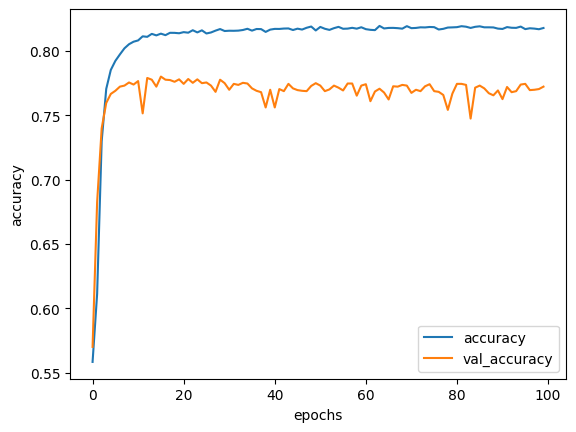

In [67]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

앞전 손실곡선의 그래프와 비슷하지만 그래프의 요동이 줄어들었다.

##### **드롭아웃 사용하기**

In [68]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, 7),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy',
              optimizer='adam',metrics=['accuracy']) # 옵티마이저 영향 안 받기 위해 건들지 않음

history = model.fit(training_padded, training_labels, epochs=100,
                    validation_data=(testing_padded, testing_labels))

Epoch 1/100
719/719 [==============================] - 3s 2ms/step - loss: 0.6855 - accuracy: 0.5589 - val_loss: 0.6809 - val_accuracy: 0.5700
Epoch 2/100
719/719 [==============================] - 2s 2ms/step - loss: 0.6696 - accuracy: 0.5843 - val_loss: 0.6467 - val_accuracy: 0.6298
Epoch 3/100
719/719 [==============================] - 2s 2ms/step - loss: 0.6152 - accuracy: 0.6717 - val_loss: 0.5738 - val_accuracy: 0.7282
Epoch 4/100
719/719 [==============================] - 2s 2ms/step - loss: 0.5469 - accuracy: 0.7263 - val_loss: 0.5173 - val_accuracy: 0.7582
Epoch 5/100
719/719 [==============================] - 3s 4ms/step - loss: 0.5064 - accuracy: 0.7544 - val_loss: 0.4991 - val_accuracy: 0.7571
Epoch 6/100
719/719 [==============================] - 3s 4ms/step - loss: 0.4855 - accuracy: 0.7644 - val_loss: 0.4770 - val_accuracy: 0.7687
Epoch 7/100
719/719 [==============================] - 2s 2ms/step - loss: 0.4691 - accuracy: 0.7734 - val_loss: 0.4745 - val_accuracy: 0.7646

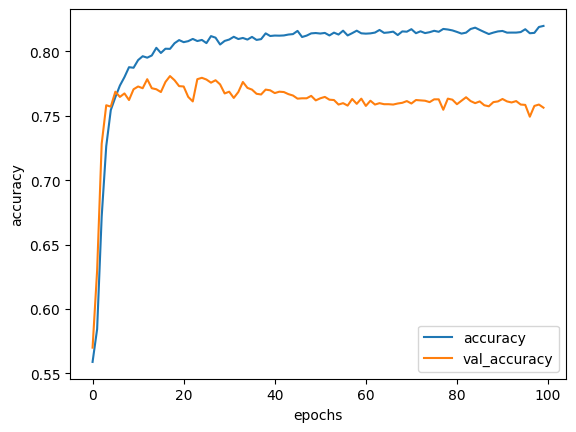

In [69]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

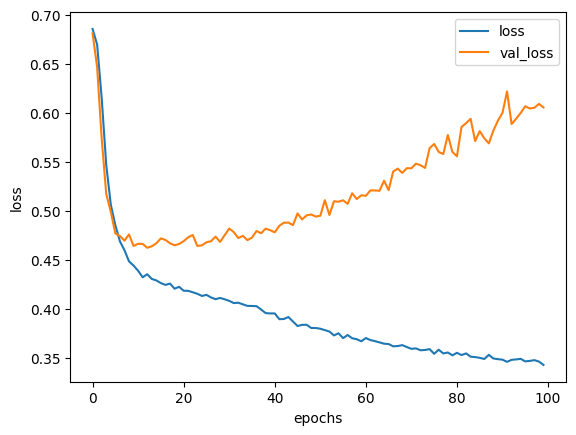

In [70]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['loss', 'val_loss'])
plt.show()

손실이 증가하는 이전 패턴이 다시 나타났다. 이전만큼 나쁘지는 않지만 잘못된 방향이다.

**매우 적은 뉴런을 사용할 때 드롭아웃을 추가하는 방법은 좋은 생각이 아니다.**

하지만 드롭아웃은 우리에게 필요한 기술이며 복잡한 구조를 위해 꼭 기억해두자

##### **규제 사용하기**

**규제** 는 가중치의 크기를 감소시켜 과대적합을 방지하는 기법이다.

일부 뉴런의 가중치가 너무 크면 규제가 이런 가중치에 패널티를 부과한다. 일반적으로 L1, L2 두 종류의 규제가 있다.



- L1 규제 : 라쏘(Lasso)라고 부른다. 층의 가중치를 0 또는 0에 가까운 값으로 만든다.

- L2 규제: 리지(ridge)라고 부르고, 가중치의 제곱을 패널티로 사용한다. 0에서 먼 값과 0에 가까운 값 사이의 차이를 증폭시키기 때문에 가중치가 강하게 규제된다.

- 일래스티넷(elestic net) 규제: 두 방식을 모두 사용할 수 있다.

여기서 살펴보는 자연처 처리 문제에는 주로 L2가 사용된다.

Dense 층의 kernel_regularizer 매개변수를 사용해 규제강도를 실수값으로 지정하는 방식으로 L2 규제를 추가할 수 있다.

**이 매개변수는 모델 향상을 위해 탐색해야 할 또 다른 하이퍼파라미터이다.**

In [74]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, 7),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(8, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',
              optimizer='adam',metrics=['accuracy'])

num_epochs = 100
history = model.fit(training_padded, training_labels, epochs=num_epochs,
                    validation_data=(testing_padded, testing_labels))

Epoch 1/100
719/719 [==============================] - 3s 3ms/step - loss: 0.7058 - accuracy: 0.5576 - val_loss: 0.6843 - val_accuracy: 0.5700
Epoch 2/100
719/719 [==============================] - 1s 2ms/step - loss: 0.6861 - accuracy: 0.5596 - val_loss: 0.6835 - val_accuracy: 0.5700
Epoch 3/100
719/719 [==============================] - 2s 2ms/step - loss: 0.6856 - accuracy: 0.5596 - val_loss: 0.6824 - val_accuracy: 0.5700
Epoch 4/100
719/719 [==============================] - 2s 2ms/step - loss: 0.6791 - accuracy: 0.5630 - val_loss: 0.6673 - val_accuracy: 0.6109
Epoch 5/100
719/719 [==============================] - 2s 3ms/step - loss: 0.6480 - accuracy: 0.6567 - val_loss: 0.6352 - val_accuracy: 0.6996
Epoch 6/100
719/719 [==============================] - 2s 2ms/step - loss: 0.6119 - accuracy: 0.7109 - val_loss: 0.6047 - val_accuracy: 0.7196
Epoch 7/100
719/719 [==============================] - 1s 2ms/step - loss: 0.5825 - accuracy: 0.7380 - val_loss: 0.5818 - val_accuracy: 0.7334

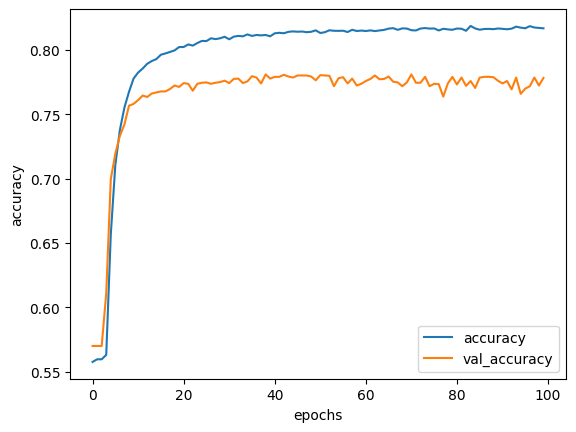

In [75]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

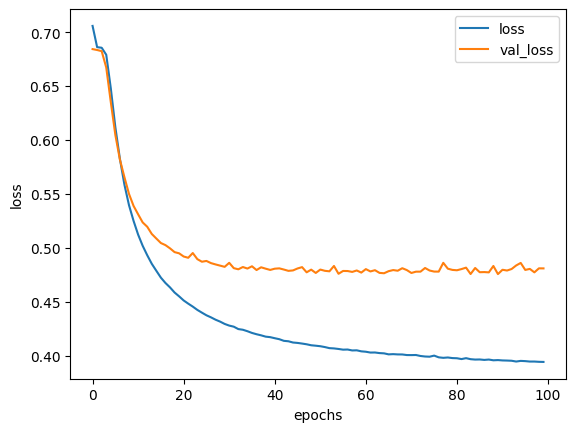

In [76]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['loss', 'val_loss'])
plt.show()

이런 간단한 모델에서 규제를 추가한 효과는 크지 않다. 하지만 훈련 손실과 검증 손실 곡선이 조금 부드러워진다.

여기서는 불필요할 수 있지만 알아두면 좋다.

##### 다른 고려 사항

지금까지의 수정 사항이 과대적합을 줄이고 모델을 크게 향상시켰지만 다른 하이퍼파라미터로도 실험할 수 있다.

예를 들어 문장의 최대 길이를 100으로 선택했지만, 최적이 아닐 수도 있다.

말뭉치를 둘러보고 더 좋은 문장 길이를 찾아보는 것이 좋다.

다음은 문장 길이를 짧은것-긴것까지 정렬해 그래프로 그리는 코드이다

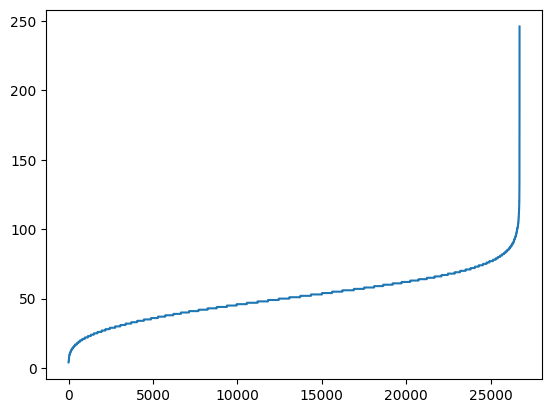

In [77]:
xs=[]
ys=[]
current_item=1
for item in sentences:
    xs.append(current_item)
    current_item=current_item+1
    ys.append(len(item))
newys = sorted(ys)

plt.plot(xs,newys)
plt.show()

26,000개 이상의 문장 중에 단어 100개 이상을 가진 문장은 200개 미만이다.

따라서 이 길이를 최대 길이로 선택하면 **불필요한 패딩을 많이 추가하게 되어 모델 성능에 영향을 미친다.**

최대 길이를 85로 줄여도 여전히 26,000개 문장에 패딩을 추가해야 한다.

#### 6.2.3. 모델을 사용해 문장 분류하기

In [78]:
sentences = ["granny starting to fear spiders in the garden might be real",
             "game of thrones season finale showing this sunday night",
             "TensorFlow book will be a best seller"]

In [83]:
from tensorflow.keras.preprocessing.text import Tokenizer
sequences = tokenizer.texts_to_sequences(sentences)
print(sequences)

[[1, 803, 1, 753, 1, 1, 1, 1, 312, 1, 97], [123, 1, 1183, 160, 1, 1, 1, 1543, 152], [1, 235, 7, 1, 1, 47, 1]]


< OOV > 에 해당하는 토큰 1이 많다. in과 the 같은 불용어는 어휘 사전에 포함되어 있지 않고

granny 와 spliders 같은 단어는 훈련 데이터에 없는 단어이기 때문이다.

**모델이 이 시퀀스를 전달하기 전에 모델이 기대하는 크기, 즉 길이로 바꾸어야 한다.**

In [84]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

print(padded)

[[   1  803    1  753    1    1    1    1  312    1   97    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [ 123    1 1183  160    1    1    1 1543  152    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0

In [85]:
print(model.predict(padded))

1/1 [==============================] - 0s 83ms/step
[[0.70551395]
 [0.02983927]
 [0.14418902]]


predict 메서드가 반환한 넘파이 배열에서 높은 값은 빈정대는 문장을 의미한다.


첫 문장 "granny starting to fear spiders in the garden might be real" 는 불용어와 패딩이 많음에도 불구하고 점수가 높다.

이는 아주 빈정대는 문장임을 나타낸다. 다른 두 문장은 훨씬 점수가 낮으므로 빈정대는 문장일 가능성이 낮다.


### 6.3. 임베딩 시각화

임베딩을 시각화하기 위해 임베딩 프로젝터를 사용한다. 여러가지 데이터셋에서 사전에 훈련한 임베딩을 기본으로 제공하지만, 여기에서 앞서 훈련한 모델의 임베딩을  이 도구로 시각화하겠다.

먼저 단어 인덱스를 반대로 매핑하는 함수가 필요하다. word_index는 단어가 key이고, 인덱스가 value이다.

임베딩 프로젝트로 시각화하려면 단어를 값으로 가지기 위해 반대로 매핑해야한다.

In [86]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

또한 임베딩 층의 가중치를 추출해야 한다.

In [87]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape)

(2000, 7)


어휘 사전 크기가 2,000개이고 임베딩 층의 차원이 7이기 때문에 (2000, 7) 출력

단어와 이에 상응하는 벡터를 확인하려면 다음과 같이 쓴다.

In [88]:
print(reverse_word_index[2])
print(weights[2])

new
[ 0.8706236  -0.76934946 -0.92500263 -0.88336724 -0.70778304 -0.76063305
 -0.78316504]


단어 'new'가 7개의 가중치로 구성된 벡터로 표현된다.

임베딩 프로젝터는 탭으로 구분된 두 개의 TSV(tab-seperated-value) 파일을 사용한다.

벡터를 저장하는 파일과 메타데이터를 저장하는 파일이다. 이파일을 생성하는 코드는 다음과 같다

In [89]:
import io

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')

for word_num in range(1, vocab_size):
  word = reverse_word_index[word_num]
  embeddings = weights[word_num]
  out_m.write(word + '\n')
  out_v.write('\t'.join([str(x) for x in embeddings]) + '\n')

out_v.close()
out_m.close()

colab을 사용한다면 다음 코드를 사용하거나 Files에서 tsv 파일 다운로드 가능

파일이 준비되면 임베딩 프로젝터에 있는 [Load] 버튼을 눌러 임베딩을 시각화 할 수 있다.

**임베딩 프로젝터는 구글에 검색하면 나옴**

그 후 'sphereize data' 체크 상자를 클릭한다. 이렇게 하면 구(sphere)로 클러스터링 하기 떄문에

이진 분류기의 특징을 명확하게 시각화할 수 있다.

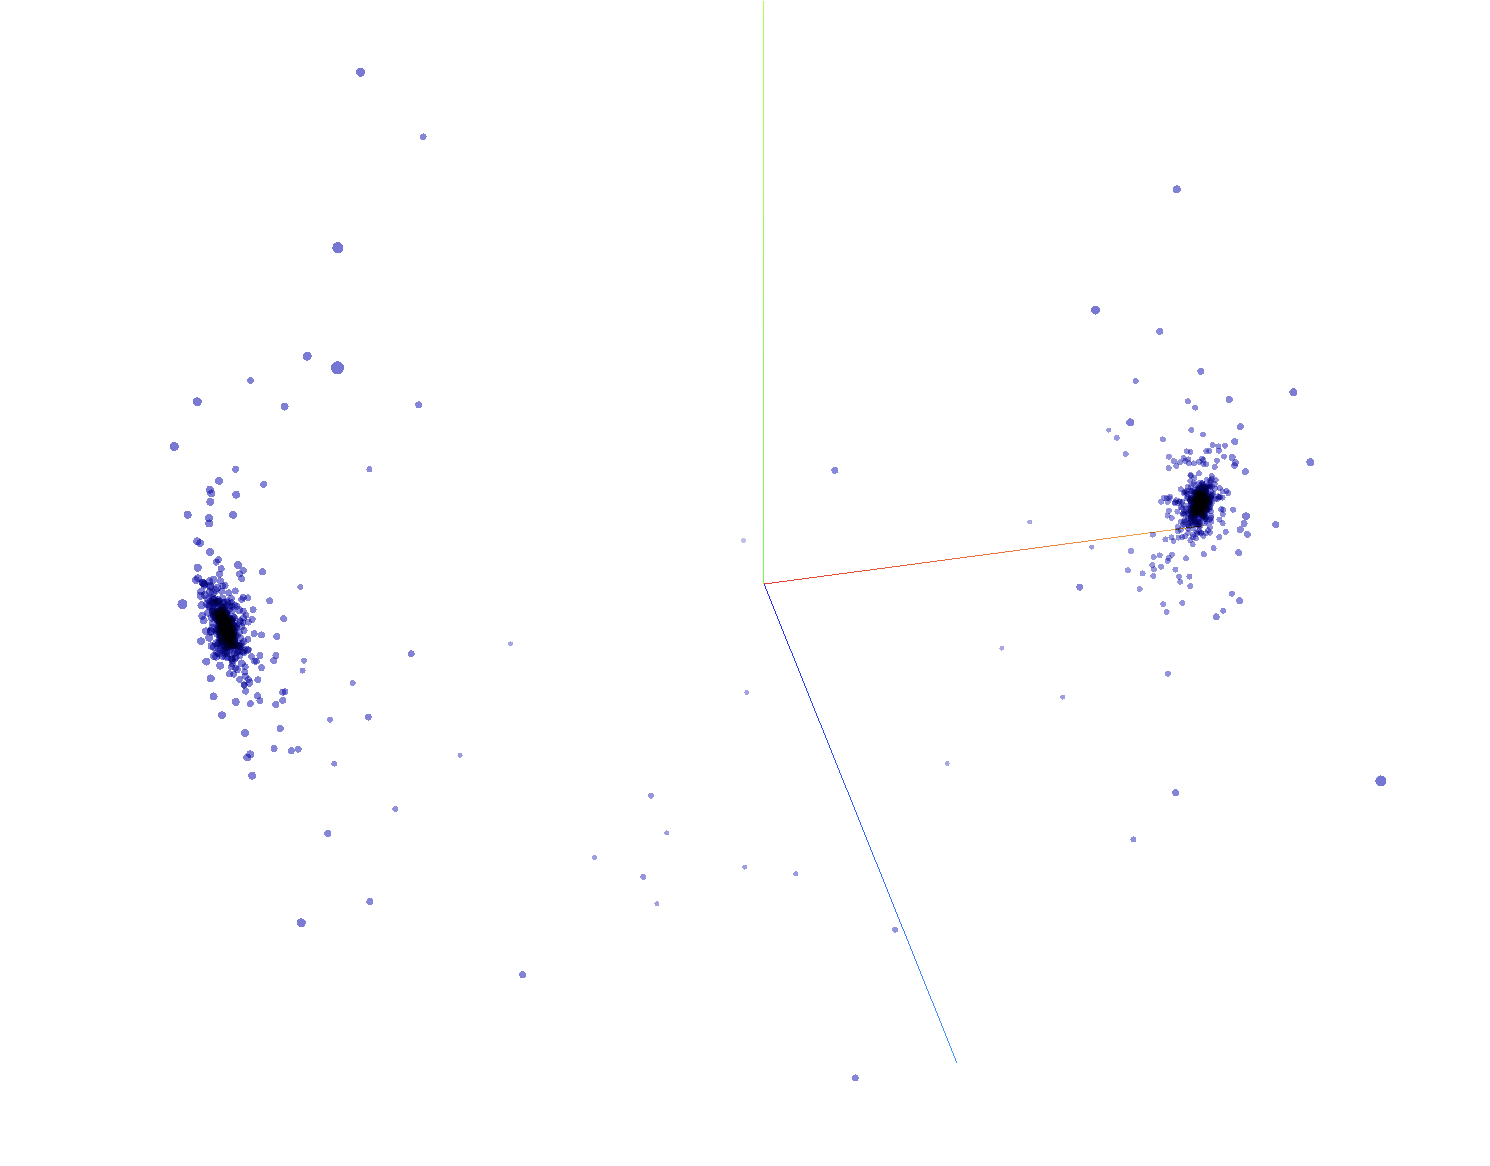

두개의 레이블 중 하나로 클러스터링 되는 경향을 띠는 것을 볼 수 있다.

### 6.4. 텐서플로 허브에서 사전 훈련된 임베딩 사용하기

**텐서플로 허브** 는 다양하고 많은 임베딩을 제공한다.

토큰화 로직을 제공하는 경우 토큰화, 시퀀스 생성, 패딩을 직접 처리할 필요도 없다.

텐서플로 허브는 구글 콜랩에 이미 설치되어있다.

sarcasm 데이터에서 토큰화, 어휘사전생성, 시퀀스 생성, 패딩 등과 같은 로직을 직접 수행하는 대신

문장과 레이블 데이터만 준비하면 텐서플로 허브를 사용해 이런 작업을 처리할 수 있다.

In [90]:
import tensorflow_hub as hub

hub_layer = hub.KerasLayer(
    "https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1",
    output_shape=[20], input_shape=[],
    dtype=tf.string, trainable=False
)

위 코드는 130GB의 구글 뉴스에서 훈련된 Swivel 임베딩을 다운로드한다.

이 층은 문장을 인코딩, 토큰화하고 단어와 Swivel 임베딩을 사용해 문장을 하나의 임베딩으로 인코딩한다.

지금까지는 단어 인코딩을 사용해 이를 기반으로 문장을 분류하는 기법을 배웠다.

이런 층을 사용하면 전체 문장을 하나의 인코딩으로 만들 수 있다.

이제 임베딩 층 대신 텐서플로 허브로 만든 층을 사용해 모델을 구성한다

In [91]:
model = tf.keras.Sequential([
    hub_layer,
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

adam = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9,
                                beta_2=0.999, amsgrad=False)

model.compile(loss='binary_crossentropy',optimizer=adam,
              metrics=['accuracy'])

In [92]:
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 20)                400020    
                                                                 
 dense_24 (Dense)            (None, 16)                336       
                                                                 
 dense_25 (Dense)            (None, 1)                 17        
                                                                 
Total params: 400373 (1.53 MB)
Trainable params: 353 (1.38 KB)
Non-trainable params: 400020 (1.53 MB)
_________________________________________________________________


In [93]:
# 넘파이 배열로 바뀐 레이블을 다시 리스트로 변경합니다.
training_labels = training_labels.tolist()
testing_labels = testing_labels.tolist()

In [95]:
num_epochs = 50
history = model.fit(training_sentences, training_labels, epochs=num_epochs,
                    validation_data=(test_sentences, testing_labels))

Epoch 1/50
719/719 [==============================] - 2s 2ms/step - loss: 0.7273 - accuracy: 0.5236 - val_loss: 0.7075 - val_accuracy: 0.5368
Epoch 2/50
719/719 [==============================] - 1s 2ms/step - loss: 0.6894 - accuracy: 0.5635 - val_loss: 0.6832 - val_accuracy: 0.5759
Epoch 3/50
719/719 [==============================] - 2s 3ms/step - loss: 0.6719 - accuracy: 0.5907 - val_loss: 0.6693 - val_accuracy: 0.6077
Epoch 4/50
719/719 [==============================] - 1s 2ms/step - loss: 0.6614 - accuracy: 0.6086 - val_loss: 0.6607 - val_accuracy: 0.6190
Epoch 5/50
719/719 [==============================] - 2s 2ms/step - loss: 0.6541 - accuracy: 0.6209 - val_loss: 0.6547 - val_accuracy: 0.6306
Epoch 6/50
719/719 [==============================] - 1s 2ms/step - loss: 0.6488 - accuracy: 0.6300 - val_loss: 0.6500 - val_accuracy: 0.6312
Epoch 7/50
719/719 [==============================] - 1s 2ms/step - loss: 0.6447 - accuracy: 0.6360 - val_loss: 0.6464 - val_accuracy: 0.6298
Epoch 

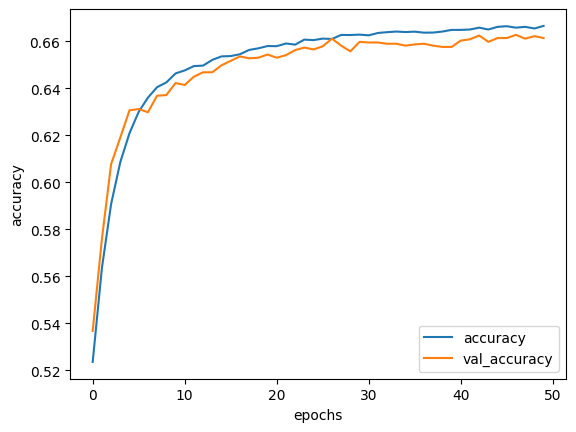

In [96]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

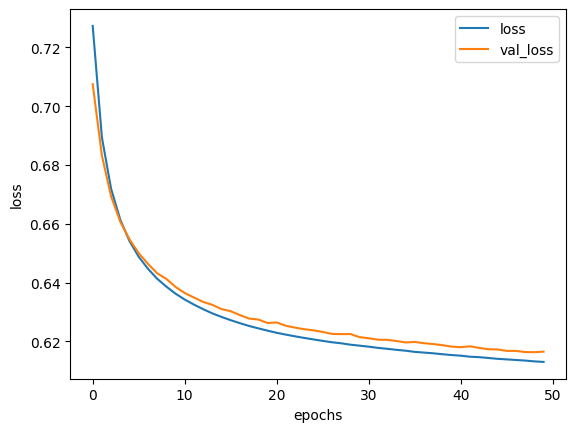

In [97]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['loss', 'val_loss'])
plt.show()

이 모델은 훈련 시 최고 정확도에 빠르게 도달하며 이전처럼 과대적합이 크게 일어나지 않는다.

50에폭까지는 훈련과 검증 정확도의 값이 매우 가깝다.

**하지만** 전반적으로 정확도가 67% 정도로 매우 낮다.

랜덤하게 예측하는 경우 정확도가 50%라는 점을 알아야 한다. 이는 인코딩을 하나의 문장 기반 인코딩으로 바꾸기 때문이다.

빈정되는 헤드라인을 구분하는 경우 개별 단어가 분류에 큰 영향을 미친다. 따라서 사전 훈련된 임베딩을 사용하면 훈련이 빠르고 과대적합이 적지만, 어떤 상황에 유용한지 생각하고 상황에 따라 항상 최선이 아닐 수 있다는 점을 잘 이해하자

지금까지의 분류기는 문장의 단어의 순서를 생각하지 않고 문장을 일련의 단어로 취급했다.

단어의 등장 순서는 문장의 의미를 결정하는 중요한 요소이므로 순서를 고려해 모델을 향상하는 방법을 알아보는 것이 좋다.